In [4]:
#!/usr/bin/env python3
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from tqdm import tqdm
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 1) Config & reproducibility
# ──────────────────────────────────────────────────────────────────────────────
STEGO_CSV   = Path("csv/stego_final.csv")
IMAGES_DIR  = Path("Images")
BATCH_SIZE  = 32
EPOCHS      = 25
LR          = 1e-3
WEIGHT_DECAY= 1e-4
LABEL_SMOOTH= 0.1
RANDOM_SEED = 42
STEP_SIZE   = 5
GAMMA       = 0.1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ──────────────────────────────────────────────────────────────────────────────
# 2) Build & split DataFrame
# ──────────────────────────────────────────────────────────────────────────────
df = pd.read_csv(STEGO_CSV)
# keep only your stego methods
df = df[df.method.isin(["lsb","iwt"])].copy()
df["binary_method"] = "stego"
df["img_path"]      = df["stego_path"]

# sample equal number of cover images
n = len(df)
all_imgs = list(IMAGES_DIR.glob("*"))
used     = set(Path(p).name for p in df["img_path"])
candidates = [str(p) for p in all_imgs if p.name not in used]
none_samp   = random.sample(candidates, n)

df_none = pd.DataFrame({
    "binary_method": ["none"]*n,
    "img_path":      none_samp
})

# combine & shuffle
df = pd.concat([df[["binary_method","img_path"]], df_none],
               ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# stratified train/val/test split
df_train, df_test = train_test_split(
    df, test_size=0.30, stratify=df["binary_method"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.20, stratify=df_train["binary_method"], random_state=RANDOM_SEED
)

# ──────────────────────────────────────────────────────────────────────────────
# 3) Dataset & DataLoaders
# ──────────────────────────────────────────────────────────────────────────────
label_map = {"none":0, "stego":1}

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

class StegoDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        img  = Image.open(row["img_path"]).convert("RGB")
        img  = self.tf(img)
        lbl  = label_map[row["binary_method"]]
        return img, lbl

train_loader = DataLoader(
    StegoDataset(df_train, train_tf),
    batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    StegoDataset(df_val,   val_tf),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    StegoDataset(df_test,  val_tf),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Model: VGG-16 w/ 2-way head (dropout is built in)
# ──────────────────────────────────────────────────────────────────────────────
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# swap out final classifier (idx 6) → 2 classes
in_f = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_f, 2)
model = model.to(DEVICE)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Loss, optimizer, scheduler, TensorBoard
# ──────────────────────────────────────────────────────────────────────────────
# up-weight stego class
class_weights = torch.tensor([1.0, 1.5], device=DEVICE)
criterion = nn.CrossEntropyLoss(
    weight=class_weights, label_smoothing=LABEL_SMOOTH
)
optimizer = Adam(
    model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

writer       = SummaryWriter("runs/stego_vgg")
train_losses = []; val_losses = []
train_accs   = []; val_accs   = []






In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) Training & validation loops
# ──────────────────────────────────────────────────────────────────────────────
def train_epoch():
    model.train()
    total_loss = total_correct = total_samples = 0
    for imgs, lbls in tqdm(train_loader, desc="Train", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out  = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()

        total_loss    += loss.item() * lbls.size(0)
        preds          = out.argmax(1)
        total_correct += (preds==lbls).sum().item()
        total_samples += lbls.size(0)
    return total_loss/total_samples, total_correct/total_samples

@torch.no_grad()
def validate():
    model.eval()
    total_loss = total_correct = total_samples = 0
    for imgs, lbls in tqdm(val_loader, desc="Val  ", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        out  = model(imgs)
        loss = criterion(out, lbls)

        total_loss    += loss.item() * lbls.size(0)
        preds          = out.argmax(1)
        total_correct += (preds==lbls).sum().item()
        total_samples += lbls.size(0)
    return total_loss/total_samples, total_correct/total_samples

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch()
    val_loss, val_acc = validate()
    scheduler.step()

    train_losses.append(tr_loss); val_losses.append(val_loss)
    train_accs.append(tr_acc);   val_accs.append(val_acc)

    writer.add_scalar("Loss/train", tr_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss, epoch)
    writer.add_scalar("Acc/train",  tr_acc,   epoch)
    writer.add_scalar("Acc/val",    val_acc,   epoch)

    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train loss={tr_loss:.4f}, acc={tr_acc:.4f}  "
          f" Val loss={val_loss:.4f}, acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg1.pth")
        print(" → new best!")

writer.close()

Epoch 1/25  Train loss=0.8474, acc=0.5033   Val loss=0.6757, acc=0.5009
 → new best!


Epoch 2/25  Train loss=0.6819, acc=0.5038   Val loss=0.6758, acc=0.5009


Epoch 3/25  Train loss=0.6895, acc=0.5024   Val loss=0.6743, acc=0.5009


Epoch 4/25  Train loss=0.6894, acc=0.4967   Val loss=0.7510, acc=0.5198
 → new best!


Epoch 5/25  Train loss=0.6896, acc=0.5165   Val loss=0.6833, acc=0.5009


Epoch 6/25  Train loss=0.6755, acc=0.4986   Val loss=0.6737, acc=0.5009


Epoch 7/25  Train loss=0.6751, acc=0.5000   Val loss=0.6731, acc=0.5009


Epoch 8/25  Train loss=0.6735, acc=0.5000   Val loss=0.6710, acc=0.5009


Epoch 9/25  Train loss=0.6704, acc=0.5000   Val loss=0.6589, acc=0.5009


Epoch 10/25  Train loss=0.6570, acc=0.5160   Val loss=0.6573, acc=0.5009


Epoch 11/25  Train loss=0.6518, acc=0.4976   Val loss=0.6335, acc=0.5009


Epoch 12/25  Train loss=0.6318, acc=0.5014   Val loss=0.6139, acc=0.5009


Epoch 13/25  Train loss=0.6155, acc=0.5160   Val loss=0.5988, acc=0.5009


Epoch 14/25  Train loss=0.5995, acc=0.5301   Val loss=0.5847, acc=0.5009


Epoch 15/25  Train loss=0.5819, acc=0.6285   Val loss=0.5681, acc=0.6855
 → new best!


Epoch 16/25  Train loss=0.5705, acc=0.6907   Val loss=0.5674, acc=0.6893
 → new best!


Epoch 17/25  Train loss=0.5685, acc=0.6883   Val loss=0.5665, acc=0.6930
 → new best!


Epoch 18/25  Train loss=0.5672, acc=0.6855   Val loss=0.5657, acc=0.6930


Epoch 19/25  Train loss=0.5673, acc=0.6846   Val loss=0.5649, acc=0.6911


Epoch 20/25  Train loss=0.5652, acc=0.6888   Val loss=0.5637, acc=0.6930


Epoch 21/25  Train loss=0.5649, acc=0.6959   Val loss=0.5636, acc=0.6930


Epoch 22/25  Train loss=0.5648, acc=0.6973   Val loss=0.5636, acc=0.6930


Epoch 23/25  Train loss=0.5614, acc=0.6963   Val loss=0.5635, acc=0.6930


Epoch 24/25  Train loss=0.5654, acc=0.6911   Val loss=0.5635, acc=0.6930


Epoch 25/25  Train loss=0.5627, acc=0.6963   Val loss=0.5634, acc=0.6930


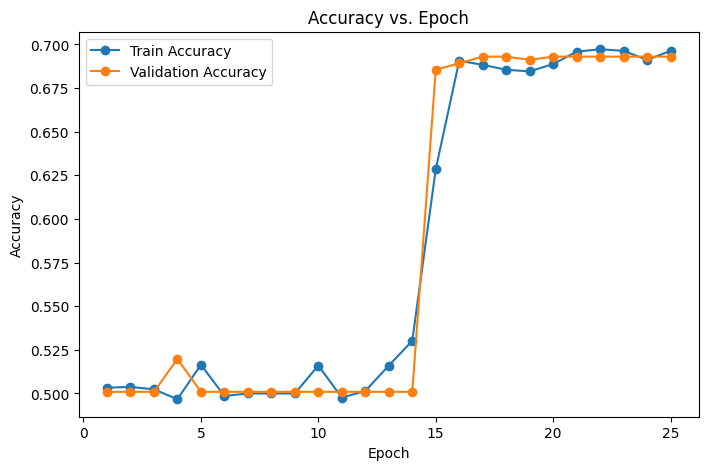

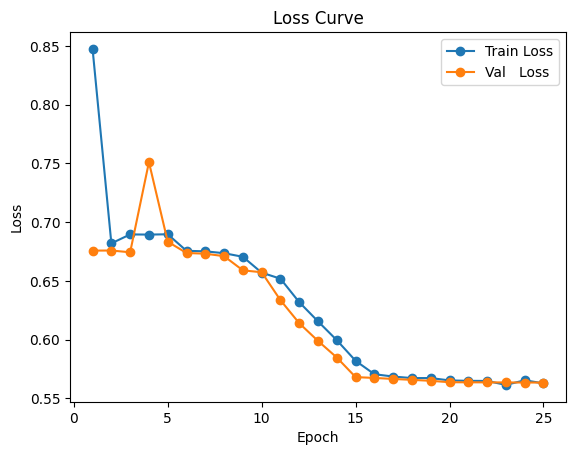

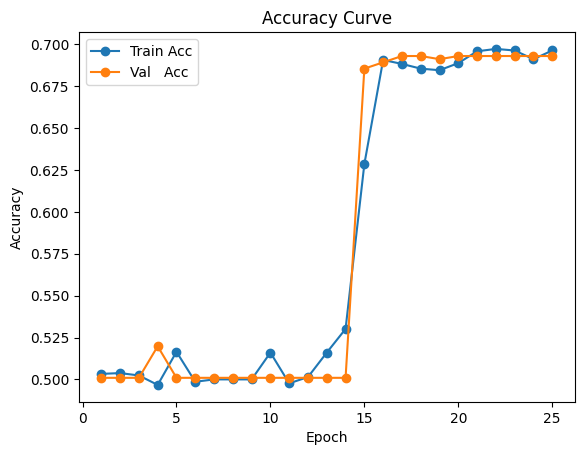

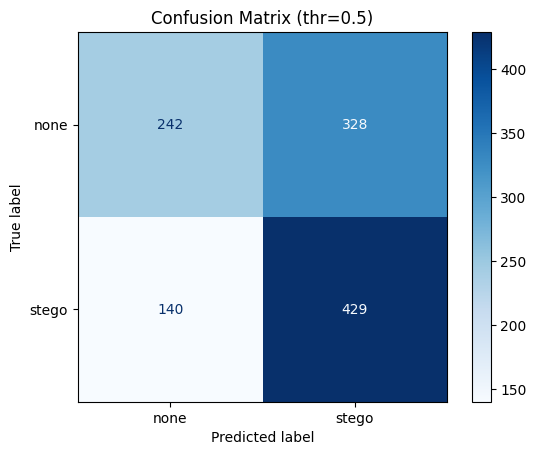

              precision    recall  f1-score   support

        none       0.63      0.42      0.51       570
       stego       0.57      0.75      0.65       569

    accuracy                           0.59      1139
   macro avg       0.60      0.59      0.58      1139
weighted avg       0.60      0.59      0.58      1139



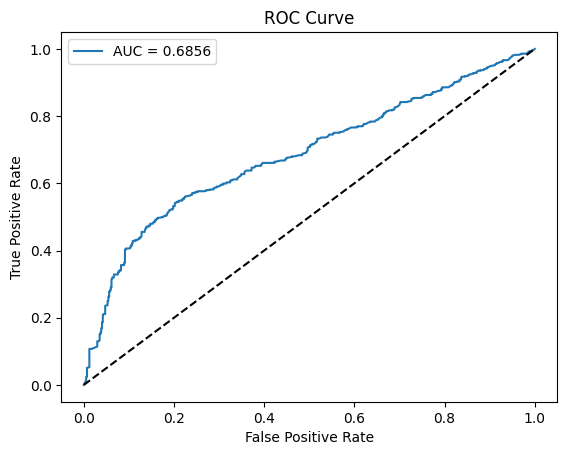

Optimal threshold (max TPR–FPR): 0.6206988


In [10]:
#15 epochs, batchsize 16──────────────────────────────────────────────────────────────────────────────
# 7) Plot Loss & Accuracy Curves
# ──────────────────────────────────────────────────────────────────────────────
epochs = range(1, EPOCHS+1)
import matplotlib.pyplot as plt

# 1) Epoch range
epochs = range(1, EPOCHS + 1)

# 2) Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accs,   marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()





plt.figure()
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='o', label='Val   Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 8) Test-Set Evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_vgg.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs= torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds= out.argmax(dim=1).cpu().numpy()

        all_labels.extend(lbls.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# Confusion matrix @ 0.5
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["none","stego"]).plot(cmap="Blues")
plt.title("Confusion Matrix (thr=0.5)"); plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=["none","stego"]))

# ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

# Optimal threshold
opt_idx = np.argmax(tpr - fpr)
print("Optimal threshold (max TPR–FPR):", _[opt_idx])

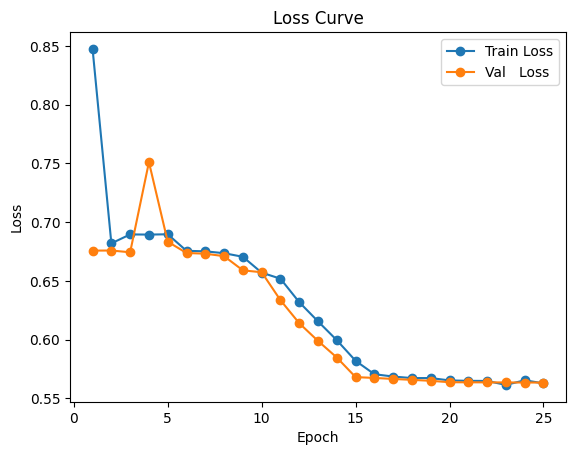

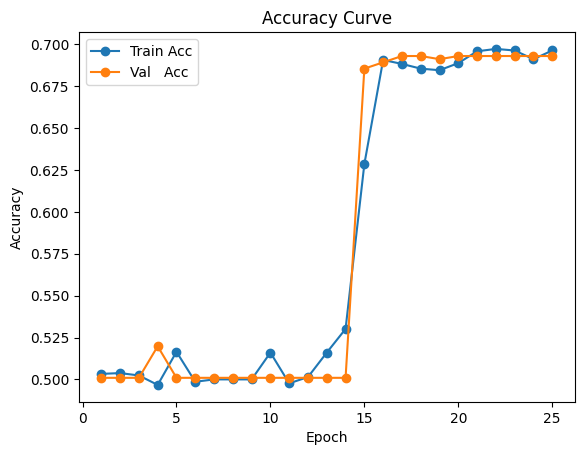

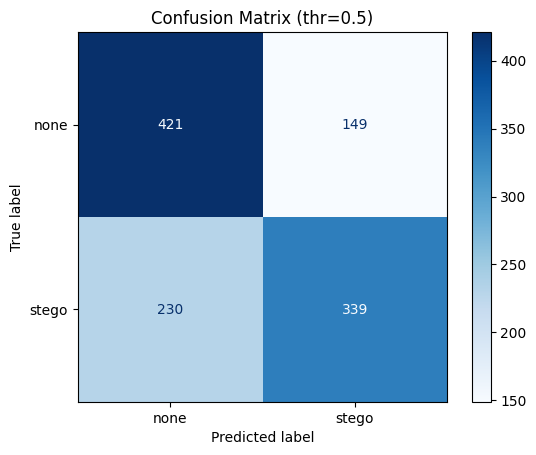

              precision    recall  f1-score   support

        none       0.65      0.74      0.69       570
       stego       0.69      0.60      0.64       569

    accuracy                           0.67      1139
   macro avg       0.67      0.67      0.67      1139
weighted avg       0.67      0.67      0.67      1139



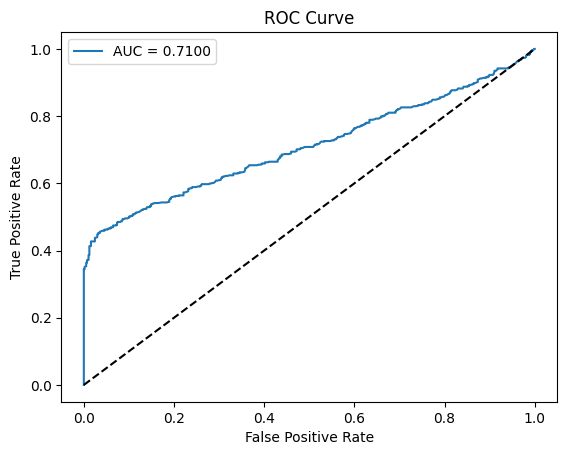

Optimal threshold (max TPR–FPR): 0.76046056


In [7]:
#25 epochs, batchsize 32 ──────────────────────────────────────────────────────────────────────────────
# 7) Plot Loss & Accuracy Curves
# ──────────────────────────────────────────────────────────────────────────────
epochs = range(1, EPOCHS+1)
plt.figure()
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='o', label='Val   Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 8) Test-Set Evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_vgg1.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs= torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds= out.argmax(dim=1).cpu().numpy()

        all_labels.extend(lbls.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# Confusion matrix @ 0.5
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["none","stego"]).plot(cmap="Blues")
plt.title("Confusion Matrix (thr=0.5)"); plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=["none","stego"]))

# ROC curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score   = roc_auc_score(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

# Optimal threshold
opt_idx = np.argmax(tpr - fpr)
print("Optimal threshold (max TPR–FPR):", _[opt_idx])